In [1]:
!pip install wget
!pip install inflect

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b475aabe6f2d465602ecf9387e55f6d63c0a388a1a8fe5b914df270440d3623d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 61.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.8.2
    Uninstalling pydantic-1.8.2:
      Successfully uninstalled pydantic-1.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.17 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.10.2 which is incompatible.
thinc 8.0.17 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3

In [2]:
import wget
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys, os, re, warnings, string
import inflect # import the inflect library
import nltk
import nltk.corpus

In [3]:
# pandas configuration 
pd.set_option('display.max_colwidth', 100) # for automatic linebreaks and multi-line cells.
pd.set_option('display.max_columns', 100) 
pd.set_option('display.width', 1000)

# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# inflect engine
inflect_engine = inflect.engine()

# English stop words
STOPWORDS = set(nltk.corpus.stopwords.words('english')) 

# download cloud word mask image
mask_url = 'https://media.self.com/photos/622912847b959736301bfb91/2:1/w_1280,c_limit/GettyImages-1301412050.jpg'
mask_wordcloud = wget.download(mask_url)
mask_wordcloud

'GettyImages-1301412050.jpg'

In [4]:
df_recipes = pd.read_csv("../input/food-com-recipes-and-user-interactions//RAW_recipes.csv")
df_interactions = pd.read_csv("../input/food-com-recipes-and-user-interactions/RAW_interactions.csv")
df = pd.concat([df_recipes, df_interactions], axis=1, join='inner')
df.head(2)

name      id  minutes  contributor_id   submitted                                                                                                 tags                                  nutrition  n_steps                                                                                                steps                                                                                          description                                                                                    ingredients  n_ingredients  user_id  recipe_id        date  rating                                                                                               review
0  arriba   baked winter squash mexican style  137739       55           47892  2005-09-16  ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...      [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11  ['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourth...  autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or swee...  ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']              7    38094      40893  2003-02-17       4  Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch o...
1            a bit different  breakfast pizza   31490       30           26278  2002-06-17  ['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...  [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9  ['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan'...  this recipe calls for the crust to be prebaked a bit before adding ingredients. feel free to cha...         ['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']              6  1293707      40893  2011-12-21       5  So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Secon...

In [5]:
print(f"Length of merged dataset: {len(df.index):,}")

Length of merged dataset: 231,637


Get numbers of non value cells in each column in the dataframe.

In [6]:
df.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
user_id              0
recipe_id            0
date                 0
rating               0
review              46
dtype: int64

It shows that 2 columns only have non value cells. description column with 4979 nan cell and review column with 46 cell.

To-Do:
    
    If description or review columns is important for the analysis then leaiving the column without droping its null rows is the best option
    else then droping its null rows is better.

In [7]:
def diff_dataframes(df_before, df_after) -> int:
    """
    Parameters
        ----------
        df_before : pandas.DataFrame
            First DataFrame
        df_after : pandas.DataFrame
            Second DataFrame
    Return: 
        ----------
        The diffrence between two dataframes rows number
    """
    diff = df_before.shape[0] - df_after.shape[0]
    print(f"Dropped Rows: {diff:,}")
    return diff

In [8]:
df_dropna = df.dropna()
diff_dataframes(df, df_dropna)
#df = df_dropna

Dropped Rows: 5,026


5026

Some recipe names contains some numbers like 0 or 123. 
To-do:-
    
    - remove numbers from 'name' column

In [9]:
df['name'] = df.name\
    .str.replace('\d+', '')\
    .str.lower()

# Dates
Date representted in two columns in the merged dataframe ['submitted', 'date']. 

Both columns as string data-type.

To-Do:

    - Convert string date to pandas date-type.
    - Extract 'year' only from both date columns in new columns.
    - Drop processed columns.

In [10]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['submitted_year'] = pd.to_datetime(df['submitted']).dt.year

# Split Nutrition column

Nutrition column represented as string-type starts and ends with brackets contains number of 7 nutrition.

    calories (#)
    total fat (PDV)
    sugar (PDV)
    sodium (PDV)
    protein (PDV)
    saturated fat (PDV)
    carbohydrates (PDV)
    
To-Do
    
    Remove brackets fo every nutrition cell.
    Split nutrition cell to 7 new columns in new DataFrame.
    Concatenate processed DataFrame and nutrition DataFrame.
    Drop nutrition column.
    

In [11]:
nutrition = ['calories', 'totalFat', 'sugar', 'sodium', 'protein', 'saturatedFat', 'carbohydrates']
df['nutrition'] = df['nutrition'].str.replace('[','').str.replace(']','')
nutrition_df = df['nutrition'].str.split(',', n=6, expand=True).astype("float32")
nutrition_df.columns = nutrition
nutrition_df.head()

calories  totalFat  sugar  sodium  protein  saturatedFat  carbohydrates
0   51.500000       0.0   13.0     0.0      2.0           0.0            4.0
1  173.399994      18.0    0.0    17.0     22.0          35.0            1.0
2  269.799988      22.0   32.0    48.0     39.0          27.0            5.0
3  368.100006      17.0   10.0     2.0     14.0           8.0           20.0
4  352.899994       1.0  337.0    23.0      3.0           0.0           28.0

In [12]:
nutrition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   calories       231637 non-null  float32
 1   totalFat       231637 non-null  float32
 2   sugar          231637 non-null  float32
 3   sodium         231637 non-null  float32
 4   protein        231637 non-null  float32
 5   saturatedFat   231637 non-null  float32
 6   carbohydrates  231637 non-null  float32
dtypes: float32(7)
memory usage: 6.2 MB


In [13]:
df = pd.concat([df, nutrition_df], axis=1, join='inner')
del(nutrition_df)
df.head(2)

name      id  minutes  contributor_id   submitted                                                                                                 tags                                nutrition  n_steps                                                                                                steps                                                                                          description                                                                                    ingredients  n_ingredients  user_id  recipe_id        date  rating                                                                                               review  year  submitted_year    calories  totalFat  sugar  sodium  protein  saturatedFat  carbohydrates
0  arriba   baked winter squash mexican style  137739       55           47892  2005-09-16  ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...      51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0       11  ['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourth...  autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or swee...  ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']              7    38094      40893  2003-02-17       4  Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch o...  2003            2005   51.500000       0.0   13.0     0.0      2.0           0.0            4.0
1            a bit different  breakfast pizza   31490       30           26278  2002-06-17  ['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...  173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0        9  ['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan'...  this recipe calls for the crust to be prebaked a bit before adding ingredients. feel free to cha...         ['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']              6  1293707      40893  2011-12-21       5  So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Secon...  2011            2002  173.399994      18.0    0.0    17.0     22.0          35.0            1.0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            231636 non-null  object 
 1   id              231637 non-null  int64  
 2   minutes         231637 non-null  int64  
 3   contributor_id  231637 non-null  int64  
 4   submitted       231637 non-null  object 
 5   tags            231637 non-null  object 
 6   nutrition       231637 non-null  object 
 7   n_steps         231637 non-null  int64  
 8   steps           231637 non-null  object 
 9   description     226658 non-null  object 
 10  ingredients     231637 non-null  object 
 11  n_ingredients   231637 non-null  int64  
 12  user_id         231637 non-null  int64  
 13  recipe_id       231637 non-null  int64  
 14  date            231637 non-null  object 
 15  rating          231637 non-null  int64  
 16  review          231591 non-null  object 
 17  year      

In string-type columns, Some numbers can be converted to words

In [15]:
def convert_number(word):
    """ convert number into words
    Parameters:
        -----
        word: string
    Return:
        ----
        if word is digit then convert into words, else just return word.
    """
    if word.isdigit(): 
        return inflect_engine.number_to_words(word)
    else:
        return word

convert_number('sd'),  convert_number('12')

('sd', 'twelve')

ٍSome columns like 'ingredients', 'tags', 'steps' and 'ingredients' are represented as string-type starts and ends with brackets. They contains string-type sentences/words splitted with comma.

To-Do:

    Remove brackets in every cell.
    Convert digits into words.

In [16]:
def convert_to_list(data):
    data = data.astype(str)
    data = data.str.replace('[','')\
        .str.replace(']','')\
        .str.replace('\'','')\
        .str.replace("'", '')\
        .str.replace("-", ' ')\
        .apply(lambda a: convert_number(a))
    return data

In [17]:
df['ingredients'] = convert_to_list(df['ingredients'])
df['ingredients'][0]

'winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt'

In [18]:
df["description"] = convert_to_list(df["description"])
df['description'][0]

'autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican inspired seasoning mix recipes are offered as suggestions.'

In [19]:
df['tags'] = convert_to_list(df['tags'])
df['tags'][0]

'60 minutes or less, time to make, course, main ingredient, cuisine, preparation, occasion, north american, side dishes, vegetables, mexican, easy, fall, holiday event, vegetarian, winter, dietary, christmas, seasonal, squash'

Check all unique tags.

In [20]:
all_tags = df.tags.str.split(', ')
unique_tags = sorted(all_tags.explode().unique())

print(unique_tags)

['', '1 day or more', '15 minutes or less', '3 steps or less', '30 minutes or less', '4 hours or less', '5 ingredients or less', '60 minutes or less', 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.', 'a1 sauce', 'african', 'american', 'amish mennonite', 'angolan', 'appetizers', 'apples', 'april fools day', 'argentine', 'artichoke', 'asian', 'asparagus', 'australian', 'austrian', 'avocado', 'bacon', 'baja', 'baked beans', 'baking', 'bananas', 'bar cookies', 'barbecue', 'bass', 'bean soup', 'beans', 'beans side dishes', 'bear', 'beef', 'beef barley soup', 'beef crock pot', 'beef kidney', 'beef liver', 'beef organ meats', 'beef ribs', 'beef sauces', 'beef sausage', 'beginner cook', 'beijing', 'belgian', 'berries', 'beverages', 'birthday', 'biscotti', 'bisques cream soups', 'black bean soup', 'black beans', 'blueberries', 'bok choys', 'brazilian', 'bread machine', 'bread pudding', 'breads', 'breakfast', 'breakfast casseroles', 'breakfast eggs', 'breakfast potatoes',

The 'tags' column contain a list of diffrent words describe the recipe. It help extracting new columns like vegan and vegetarian.

To-do:

    Create 2 columns for vegan and vegetarian.
    Create a third one for diet.

In [21]:
# Add vegetarian and vegan boolean columns
df['vegetarian'] = df['tags'].str.contains('vegetarian')
df['vegan'] = df['tags'].str.contains('vegan')
df.tags[0], df.vegetarian[0]

('60 minutes or less, time to make, course, main ingredient, cuisine, preparation, occasion, north american, side dishes, vegetables, mexican, easy, fall, holiday event, vegetarian, winter, dietary, christmas, seasonal, squash',
 True)

In [22]:
def diet_conditions(df):
    if not df['vegetarian'] and not df['vegan']:
        return 'regular'
    elif df['vegetarian'] and not df['vegan']:
        return 'vegetarian'
    else:
        return 'vegan'
    
df['diet'] = df.apply(diet_conditions, axis=1)
df.drop(columns=['vegetarian', 'vegan'], inplace=True)
df.head(2)

name      id  minutes  contributor_id   submitted                                                                                                 tags                                nutrition  n_steps                                                                                                steps                                                                                          description                                                                    ingredients  n_ingredients  user_id  recipe_id        date  rating                                                                                               review  year  submitted_year    calories  totalFat  sugar  sodium  protein  saturatedFat  carbohydrates        diet
0  arriba   baked winter squash mexican style  137739       55           47892  2005-09-16  60 minutes or less, time to make, course, main ingredient, cuisine, preparation, occasion, north...      51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0       11  ['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourth...  autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or swee...  winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt              7    38094      40893  2003-02-17       4  Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch o...  2003            2005   51.500000       0.0   13.0     0.0      2.0           0.0            4.0  vegetarian
1            a bit different  breakfast pizza   31490       30           26278  2002-06-17  30 minutes or less, time to make, course, main ingredient, cuisine, preparation, occasion, north...  173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0        9  ['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan'...  this recipe calls for the crust to be prebaked a bit before adding ingredients. feel free to cha...       prepared pizza crust, sausage patty, eggs, milk, salt and pepper, cheese              6  1293707      40893  2011-12-21       5  So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Secon...  2011            2002  173.399994      18.0    0.0    17.0     22.0          35.0            1.0     regular

### Recalculate number of steps

Trying to calculate number of steps by:

    - Removing brackets from string.
    - Splitting steps column by comma.
    - Calculating the length list of steps.

In [23]:
df['steps'] = df['steps']\
    .str.replace('[','')\
    .str.replace(']','')\
    .str.replace('\'','')

In [24]:
# n splits ',' + 1
#df['N_steps'] = df['steps'].str.count(',')+1
df['N_steps'] = df['steps'].apply(lambda a: len(list(a.split(', '))))

In [25]:
df[df.n_steps == 1][['name', 'steps', 'n_steps', 'N_steps']].head(10)

name                                                                                                steps  n_steps  N_steps
92                       stove top  bbq  beef or pork ribs  cut all ribs into serving size pieces sprinkle ribs with salt in a dutch oven , brown ribs on al...        1        4
249                                    outback   steak rub                         mix , sprinkle lightly on your favorite cut of beef , then cook as desired !        1        3
328                                   berry good  smoothie                                                          mix all ingredients in blender until smooth        1        1
520                                            sexy  sauce  whisk all ingredients together , bring to boil in medium saucepan , and simmer 45 minutes until ...        1        3
531                                  souped up  veggie dip                                                                       mix together and dip dip dip !        1        1
593  all purpose  marinade  especially nice used with beef                                                             combine all the ingredients and mix well        1        1
617                                    old style  pancakes                                                                      beat mixture and fry on griddle        1        1
702                               another  cajun seasoning                                                  combine all ingredients in a small jar & shake well        1        1
768                                                  bread                                                                       bake 50 minutes at 400 degrees        1        1
818                  minute  fat free  veggie soup for one                                put all ingredients in a saucepan and simmer until veggies are tender        1        1

Review column can have some preprocessing.

    - Converting to string-type for some Nulls to be empty string''.
    - Converting to lowercase
    - Removing HTML tags
    - convert digits to words.
    - Removing Punctuations
    - Snowball Stemming 
    - Removing stopwords
     

In [26]:
def remove_punctuation(text):
    """
    Parameters:
        ----
        test: string
    Return:
        ----
        A text after removing punctuation.
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
 
input_str = "Hey, did you know that the summer break is coming? Amazing right !! It's only 5 more days !!"
remove_punctuation(input_str)

'Hey did you know that the summer break is coming Amazing right  Its only 5 more days '

In [27]:
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 
# Some HTML texts can also contain entities that are not enclosed in brackets, such as '&nsbm'.
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

In [28]:
def review_preprocessing(sentence, stem=None)->str:
    """
        Parameters
        ----------
        sentence : String
    Return: 
        ----------
        The sentence after applying diffrent preprocessing methods.
    """
    #if type(sentence) is not str: 
    #    print(sentence)
    #assert( type(sentence) is str )
    sentence = str(sentence)
    # Converting to lowercase
    sentence = sentence.lower() 
    # Removing HTML tags
    sentence = cleanhtml(sentence)      
    # Removing Punctuations
    #sentence = re.sub(r'[?|!|\'|"|#]', r'',sentence)
    #sentence = re.sub(r'[.|,|)|(|\|/]', r' ',sentence)      
    sentence = remove_punctuation(sentence)
    
    if stem == 'stem':
    # Stemming and removing stopwords
        snow = nltk.stem.SnowballStemmer('english')
        words = [snow.stem(convert_number(word)) for word in sentence.split() if word not in STOPWORDS] 
    elif stem == 'lemmatize':
        # WordNetLemmatizing
        lemmatizer = nltk.stem.WordNetLemmatizer()
        words = [lemmatizer.lemmatize(convert_number(word)) for word in sentence.split() if word not in STOPWORDS] 
    else: 
        words = [convert_number(word) for word in sentence.split() if word not in STOPWORDS] 
        
    # Remove dublicated words
    sentence = " ".join(sorted(set(words), key=words.index))
    return sentence

df['clean_review'] = df['review'].apply(review_preprocessing)
df[['name', 'review', 'clean_review']]

name                                                                                               review                                                                                         clean_review
0         arriba   baked winter squash mexican style  Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch o...  great salad cooked top stove fifteen minutesadded shake cayenne pinch salt used low fat sour cre...
1                   a bit different  breakfast pizza  So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Secon...  simple delicious great chilly fall evening doubled second time around forgot remaining cumin usu...
2                          all in the kitchen  chili  This worked very well and is EASY.  I used not quite a whole package (10oz) of white chips.  Great!                                     worked well easy used quite whole package 10oz white chips great
3                                 alouette  potatoes                                 I made the Mexican topping and took it to bunko.  Everyone loved it.                                                       made mexican topping took bunko everyone loved
4                 amish  tomato ketchup  for canning                            Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!                                        made cheddar bacon topping adding sprinkling black pepper yum
...                                              ...                                                                                                  ...                                                                                                  ...
231632                                   zydeco soup  Yummy! I didn't add mushrooms since my hubby doesn't like them and I mixed the cheese into the m...  yummy didnt add mushrooms since hubby doesnt like mixed cheese mixture instead top also used spi...
231633                              zydeco spice mix  Very good.  I served this as a side with some sour cream chicken enchiladas, and we used the new...  good served side sour cream chicken enchiladas used new gold corn chips next time ill add little...
231634                     zydeco ya ya deviled eggs  I made this with half the amount of mushrooms (finely chopped instead of sliced).  I cut out the...  made half amount mushrooms finely chopped instead sliced cut peppers onion added two tablespoons...
231635        cookies by design   cookies on a stick  These are SO good! I forgot to put the cheese in my first batch, and they were still delicious. ...  good forgot put cheese first batch still delicious made mini muffin tins doubled recipe double t...
231636  cookies by design   sugar shortbread cookies  We're trying the Atkins diet and this was wonderful for Sunday breakfast! I used pork sausage, r...  trying atkins diet wonderful sunday breakfast used pork sausage red peppers sp hot sauce tasty i...

[231637 rows x 3 columns]

Some processed columns need to be dropped processed columns.

In [29]:
df.drop(columns=['nutrition', 'n_steps', 'submitted', 'date', 'review'], inplace=True)

# Check outliers using box plot
Box plots visually show the distribution of numerical data and skewness through displaying the data quartiles (or percentiles) and averages.

In [30]:
def BoxPlot(df, columns):
    plt.style.use('ggplot')
    n = len(columns)
    if n % 2 == 0:
        fig, axis = plt.subplots(2, int(n/2), figsize=(20, 10))
    elif n % 3 == 0:
        fig, axis = plt.subplots(3, n/3, figsize=(20, 15))
    else:
        fig, axis = plt.subplots(1, n, figsize=(20, 5))
    axis = axis.ravel()

    for index, ax in enumerate(axis):
        sns.boxplot(
            data = df[check_ouliers_column[index]], 
            ax = ax
        )
        ax.set(title = check_ouliers_column[index])

    plt.tight_layout()
    plt.show()

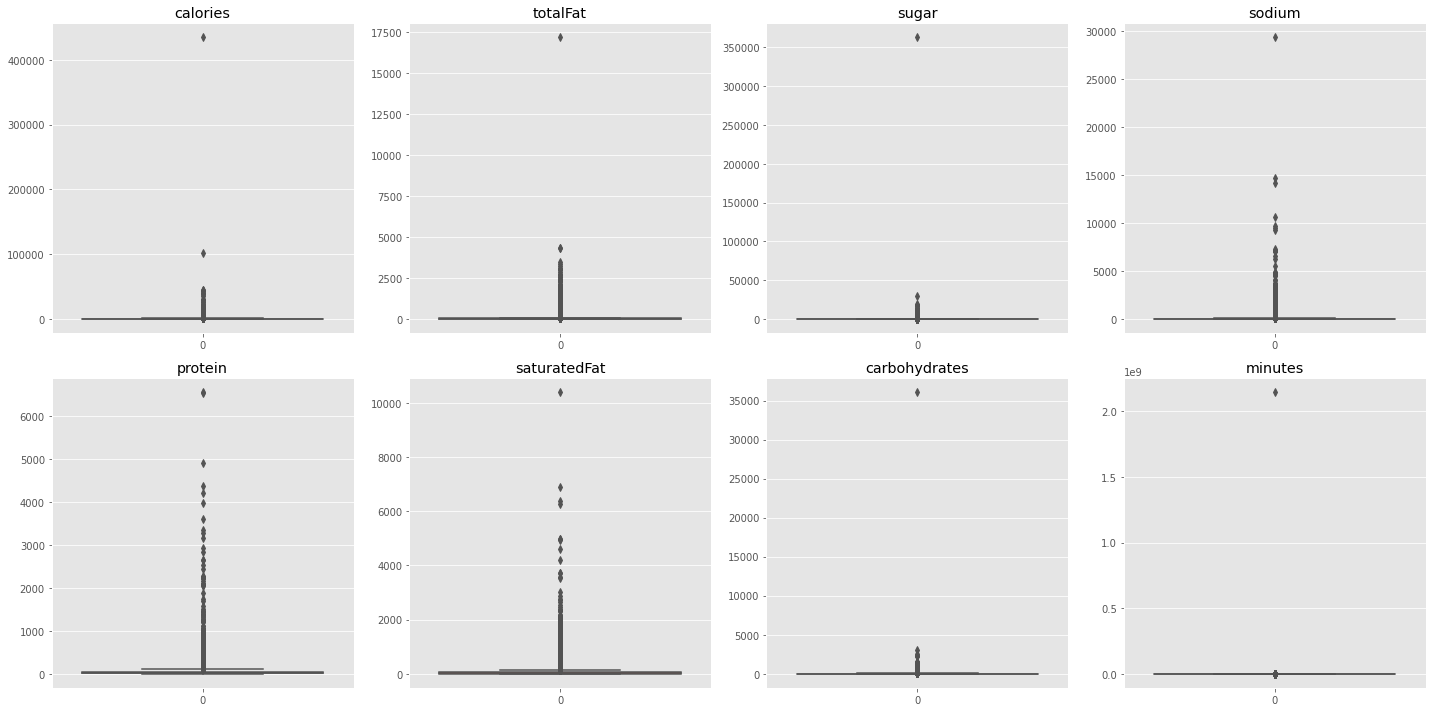

In [31]:
check_ouliers_column = nutrition + ['minutes']
BoxPlot(df, check_ouliers_column)

Some data columns have many outlier points need to be cleaned.

## Remove Outliers:
    - lower bound = Q1 - 1.5 * IQR 
    - upper bound = Q3 + 1.5 * IQR.

In [32]:
# remove outliers
def remove_outliers(df, columns, min_q=0.05, max_q=0.95, ratio=1.5):
    """
    Parameters
        ----------
        df : pandas.DataFrame
            DataFrame
        columns : List
            Calumns names 
        min_q : minimum quantile
        max_q : maximam quantile
        ratio : ratio
    Return: 
        ----------
        pandas.DataFrame after removing outliers out of minimum and minimum quartiles.
    """
    for colunm in columns:
        # IQR(Interquartile range): defines the range covered by minimum and minimum quartiles.
        IQR = df[colunm].quantile(max_q) - df[colunm].quantile(min_q)
        colmin = df[colunm].quantile(min_q) - ratio * IQR
        colmax = df[colunm].quantile(max_q) + ratio * IQR
        df = df[ (df[colunm] < colmax) & (df[colunm] > colmin) ]
    return df

df_cleaned = remove_outliers(df, check_ouliers_column)
print(diff_dataframes(df, df_cleaned))
df = df_cleaned

Dropped Rows: 14,044
14044


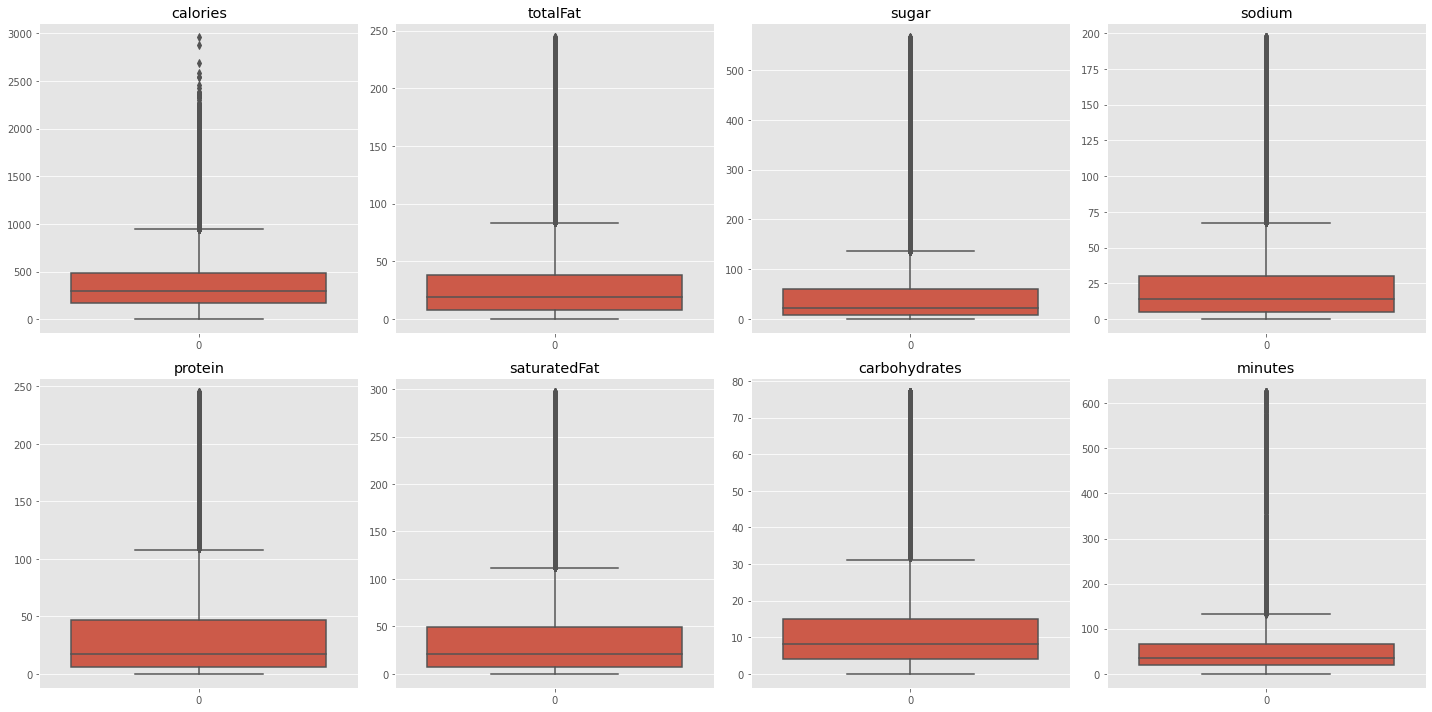

In [33]:
BoxPlot(df, check_ouliers_column)

In [34]:
df.sort_values('minutes', ascending=False).head(2)

name      id  minutes  contributor_id                                                                                                 tags                                                                                                steps                                                                                          description                                                                                          ingredients  n_ingredients     user_id  recipe_id  rating  year  submitted_year    calories  totalFat  sugar  sodium  protein  saturatedFat  carbohydrates     diet  N_steps                                                                                         clean_review
20685            beef stew with barley  crock pot   53404      625           51669  weeknight, time to make, course, main ingredient, preparation, occasion, main dish, beef, fall, ...  brown meat with chopped onion in oil and transfer to 6 quart crock pot, add remaining ingredient...  this non gravy stew recipe is a combination of many recipes, tailored to the flavours i like bes...  stewing beef, cooking oil, onion, barley, dried thyme, dried marjoram, dried rosemary, black pep...             15       33443      44987       4  2003            2003  313.399994      10.0   20.0    27.0     52.0          11.0           13.0  regular        7  good used sharp cheddar added fresh ground black pepper found bit bland served canned tomatoes t...
17705  barbecue style chicken for the slow cooker  323242      625          593726  course, preparation, healthy, main dish, easy, low fat, crock pot slow cooker, dietary, low satu...  in a 3-1 / 2- to 4-quart slow cooker place the potatoes , sweet pepper , and onion, sprinkle tap...                                                               from better homes and gardens website.  potatoes, green sweet pepper, onion, quick cooking tapioca, skinless chicken thighs, tomato sauc...             11  2001635824     326076       5  2017            2008  434.600006      14.0   62.0    31.0     96.0          11.0           12.0  regular       19                                    used vegetable pizza recipe spread croissant crust everyone loved

Plotting a distribution of number of steps after cutting some outliers.

In [35]:
print(f"Unique number of steps: {len(df.N_steps.unique())}")
print(f"Max number of steps: {max(df.N_steps.unique())}")
print(f"Min number of steps: {min(df.N_steps.unique())}")

fig = px.histogram(df, x="N_steps", title="Distribution of N steps")
fig.show()

Unique number of steps: 125
Max number of steps: 152
Min number of steps: 1


Plotting a distribution of number of ingredients after cutting some outliers.

In [36]:
print(f"Unique number of ingredients: {len(df.n_ingredients.unique())}")
print(f"Max number of ingredients: {max(df.n_ingredients.unique())}")
print(f"Min number of ingredients: {min(df.n_ingredients.unique())}")
fig = px.histogram(df, x="n_ingredients", title="Distribution of N ingredients")
fig.show()

Unique number of ingredients: 41
Max number of ingredients: 43
Min number of ingredients: 1


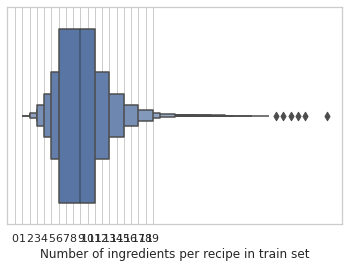

In [37]:
sns.set(style = "whitegrid")
ax = sns.boxenplot(x = df['n_ingredients'])
ax.set_xticks(np.arange(0,20))
ax.set_xlabel('Number of ingredients per recipe in train set')
plt.show()

Plotting a distribution of number of making time in minutes after cutting some outliers.

In [38]:
print(f"Unique making time 'minutes': {len(df.minutes.unique())}")
print(f"Max making time 'minutes': {max(df.minutes.unique())}")
print(f"Min making time 'minutes': {min(df.minutes.unique())}")
fig = px.histogram(df, x="minutes", title="Distribution of Recipe Making Time")
fig.show()

Unique making time 'minutes': 400
Max making time 'minutes': 625
Min making time 'minutes': 0


Some values in name column 'recipes' are dublicated.

To-do:

    - Choose the recipe with best ratting and drop the rest

In [39]:
names = df.name
duplicated_names = df[
    names.isin(
        names[names.duplicated()]
    )
].sort_values(["name", "rating"], ascending= False)

duplicated_names.head(2)

name     id  minutes  contributor_id                                                                                                 tags                                                                                                steps                                           description                                                                                          ingredients  n_ingredients  user_id  recipe_id  rating  year  submitted_year    calories  totalFat  sugar  sodium  protein  saturatedFat  carbohydrates        diet  N_steps                                                                                         clean_review
231113  zucchini cilantro dip   4636       15            1939          15 minutes or less, time to make, course, preparation, appetizers, dips, number of servings  line a large baking sheet with a clean dish towel, spread zucchini over towel, sprinkle with 3 /...                                                   nan  zucchini, garbanzo beans, cilantro leaf, garlic, seasoned rice vinegar with roasted garlic, oliv...              7   678366     379974       5  2009            1999  745.299988      68.0   47.0    31.0     40.0          30.0           25.0     regular       24  tagged realised made five minute artizan bread called thinkand ive using since found recipe grea...
231526  zucchini cilantro dip  15267       30           21752  30 minutes or less, time to make, course, main ingredient, preparation, occasion, appetizers, ve...  place grated zucchini in colander and sprinkle with salt, let drain 30 minutes, rinse zucchini, ...  if you like cilantro you are going to love this dip!  zucchini, salt, plain yogurt, sour cream, olive oil, white wine vinegar, fresh cilantro, garlic,...             12  2945846     108105       5  2013            2001  419.100006      55.0   37.0    29.0     19.0          78.0            5.0  vegetarian       17  flavor dish incredible changes made based comments read used low salt soy sauce cut chicken chun...

In [40]:
#df = df.sort_values(["name", "rating"], ascending= False)\
#        .drop_duplicates(subset=["name", "rating"], keep="first")

Plotting the rating distribution for recipes.

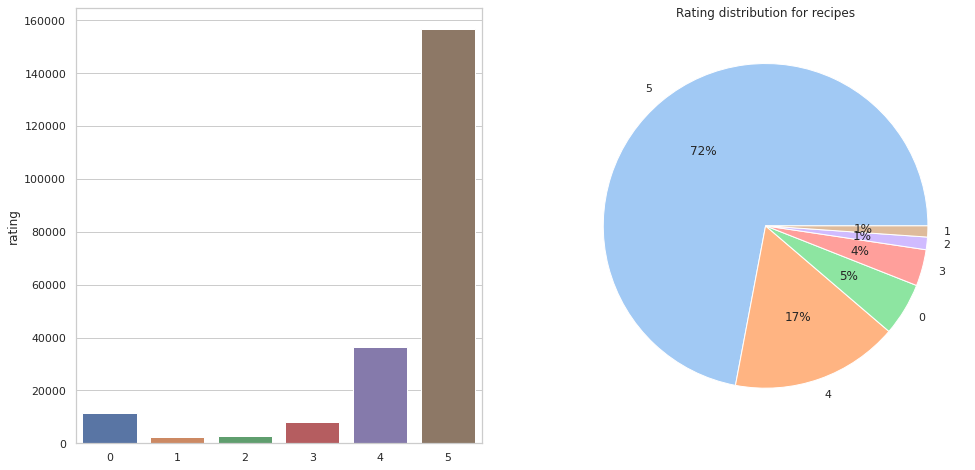

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(
    x = df.rating.value_counts().index, 
    y = df.rating.value_counts(),
    ax = ax1
);
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:6]
#create pie chart
ax2.pie(
    df.rating.value_counts(), 
    labels = df.rating.value_counts().index, 
    colors = colors, 
    autopct='%.0f%%'
);
plt.title("Rating distribution for recipes");

Plotting the rating distribution for recipes.

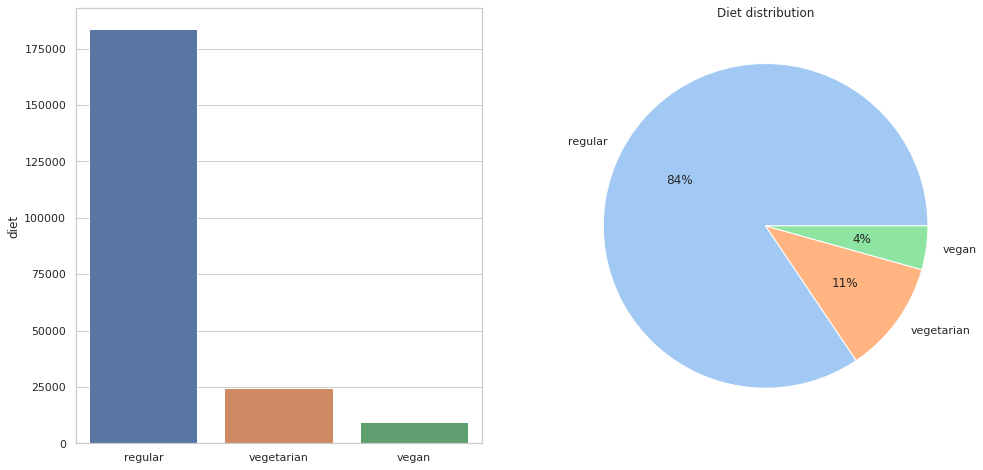

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(
    x = df.diet.value_counts().index, 
    y = df.diet.value_counts(),
    ax = ax1
);
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:3]
#create pie chart
ax2.pie(
    df.diet.value_counts(), 
    labels = df.diet.value_counts().index, 
    colors = colors, 
    autopct='%.0f%%'
);
plt.title("Diet distribution");

We can create a Sentiment column for Positive/Negative based on ratings

In [43]:
#df['sentiment'] = df.rating.apply(lambda x: 'Positive' if x > 3 else 'Negative')

Plotting the number of recipes by year for each diet.

In [44]:
df_veg = df.groupby(['year', 'diet']).agg(
    recipe_count = ('id', 'count')
).reset_index()
df_veg.head()

year        diet  recipe_count
0  2000     regular            22
1  2000       vegan             1
2  2000  vegetarian             2
3  2001     regular           484
4  2001       vegan            41

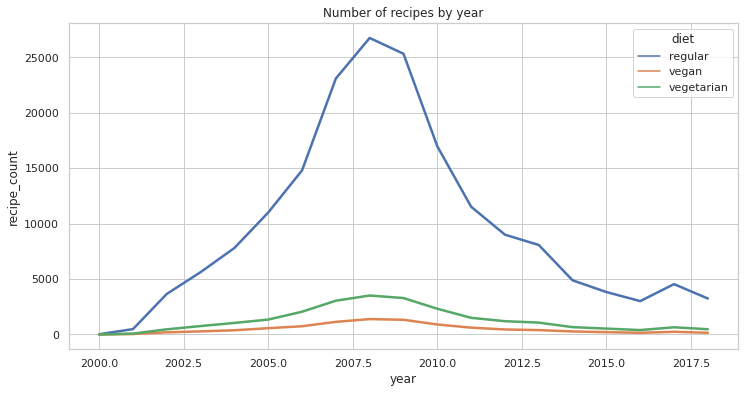

In [45]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data = df_veg, 
    x = 'year', 
    y = 'recipe_count', 
    hue = 'diet', 
    linewidth = 2.5
);

ax.set_title('Number of recipes by year');

Correlation plot as heat map.

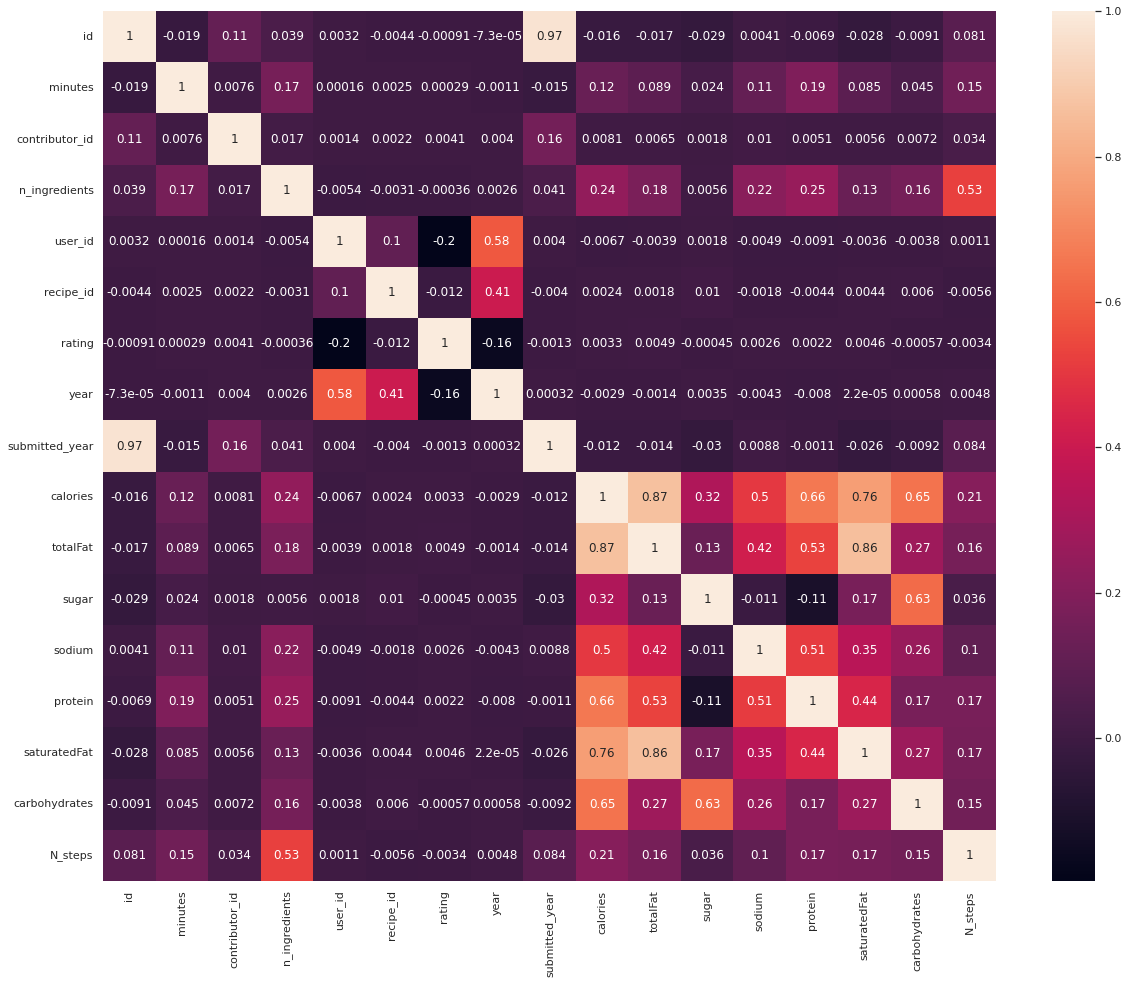

In [46]:
plt.figure(figsize=(20,16))
sns.heatmap(df.corr(), annot=True);

In [47]:
df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'tags', 'steps', 'description', 'ingredients', 'n_ingredients', 'user_id', 'recipe_id', 'rating', 'year', 'submitted_year', 'calories', 'totalFat', 'sugar', 'sodium', 'protein', 'saturatedFat', 'carbohydrates', 'diet', 'N_steps', 'clean_review'], dtype='object')

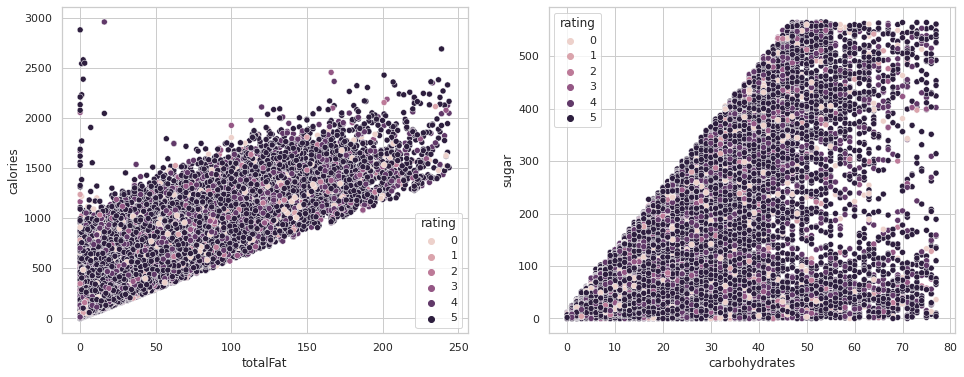

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6));
sns.scatterplot(data=df, x="totalFat", y="calories", hue="rating",ax=ax1);
sns.scatterplot(data=df, x="carbohydrates", y="sugar" , hue="rating",ax=ax2);

Word cloud of some string-type columns to see the most used words in each column.

In [49]:
def WordCloudPlot(df, column, save=False):
    # text = ' '.join(df[column].tolist())
    text = df[column].str.cat(sep=' ')
    # Generate a word cloud image
    mask = np.array(Image.open(mask_wordcloud))
    wcloud = WordCloud(
        stopwords=STOPWORDS, 
        background_color="white", 
        mode="RGBA", 
        max_words=1000, 
        mask=mask
    ).generate(text)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[14,10])
    plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word cloud for {column}")
    # store to file
    if save:
        plt.savefig(f"img/wcloud_{column}.png", format="png")
    
    plt.show()

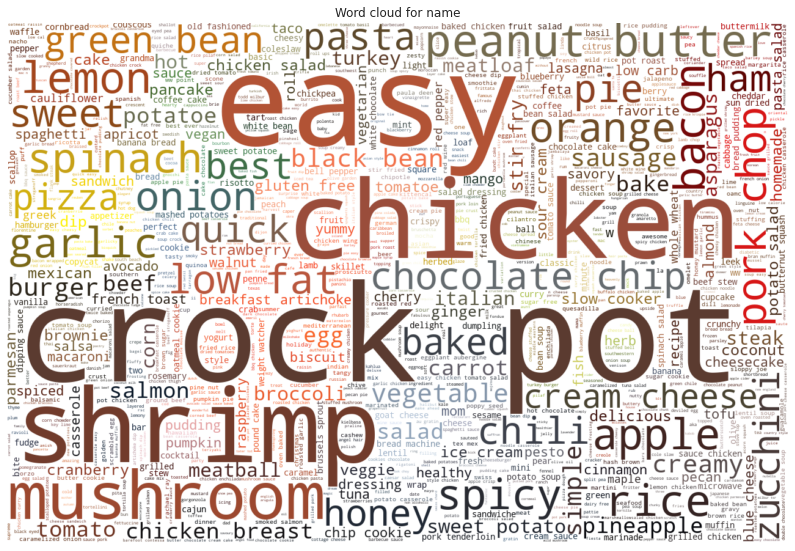

In [50]:
WordCloudPlot(df, 'name')

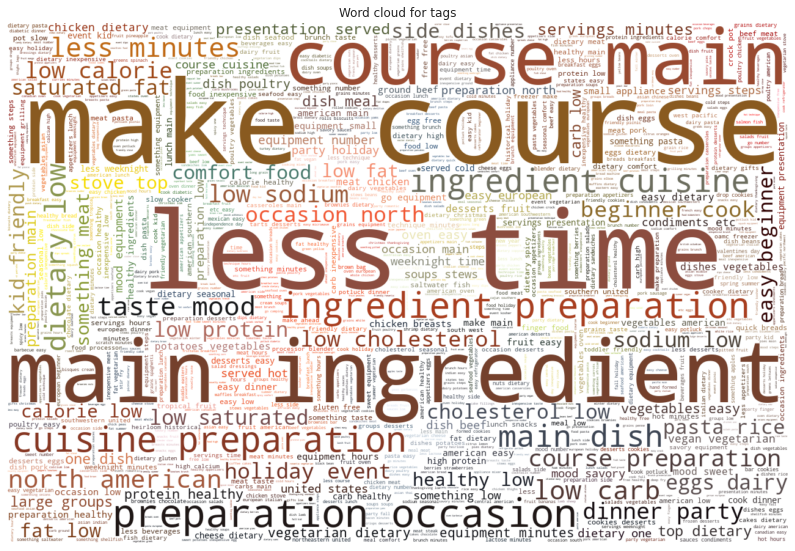

In [51]:
WordCloudPlot(df, 'tags')

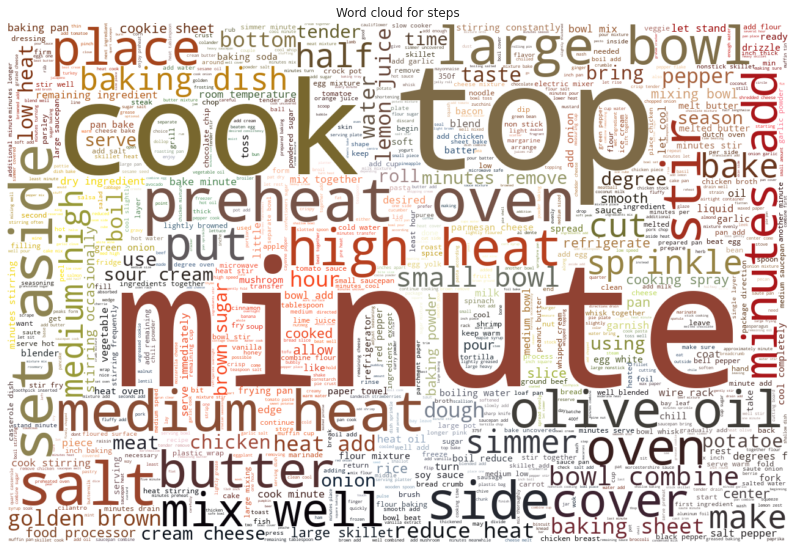

In [52]:
WordCloudPlot(df, 'steps')

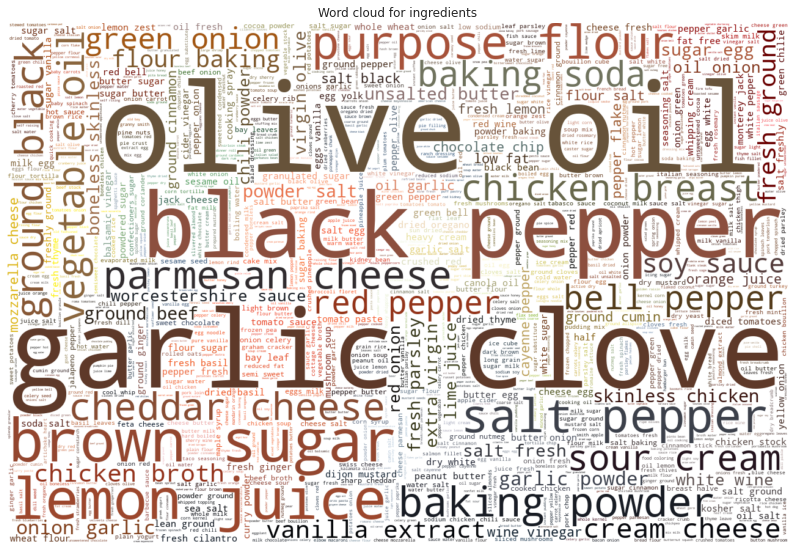

In [53]:
WordCloudPlot(df, 'ingredients')

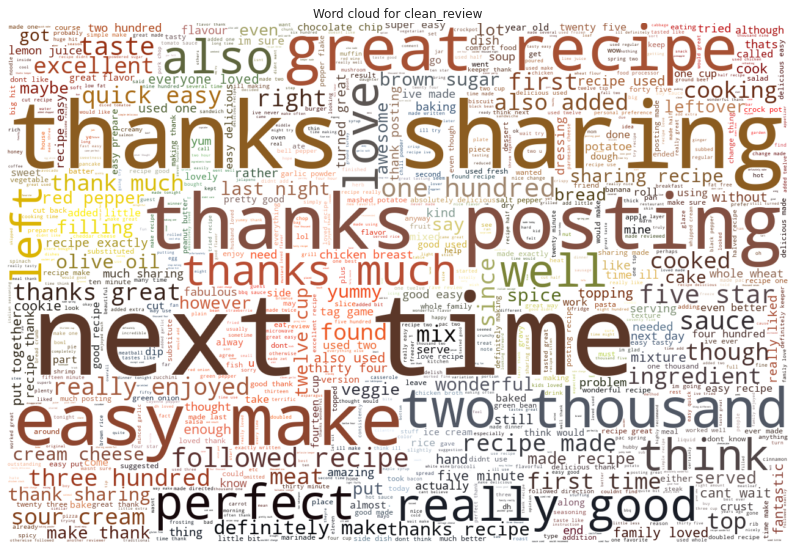

In [54]:
WordCloudPlot(df, 'clean_review')

Reset index and save dataset.

In [55]:
df.reset_index(drop=True, inplace=True)

In [56]:
save_dir = 'Food.com Recipes and Interactions/Exploratory data analysis'
os.makedirs(save_dir, exist_ok=True)  
df.to_csv(save_dir+'/food_out.csv') 